In [ ]:
import pandas as pd
import numpy as np
import plotly_express as px
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import GroupKFold, KFold
import lightgbm as lgb

In [ ]:
path = '../input/optiver-realized-volatility-prediction'

**In this notebook will try to figure out what this competition is really asking us to predict**

<br><br>     
     
     
 Below are the questions after the first glance of data;
  
     1) what is meant by Volatility
  
     2) How to read parquet files like book and trade.
     
     4) what is book and trade
      
     5) Why did they use wap formula as bidask + askbid but not bidbid or askask
  
     6) What fields are given in train file and what is given in the test file to predict

**Volatility**


It is simply the fluctuation of prices for a given time period. For example, the prices of cryptocurrencies and the  returns on crypto are unpredictable. 



**Parquet files**

To get a good understanding of what is parquet file and how different it is from csv, you can read below article

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and


In short, when you have huge data and nested schemas "parquet is the file format" to use. 

You can get an idea from the below screen shot;

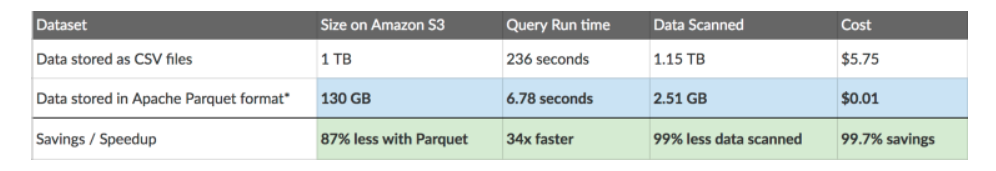



To read parquet file we can use pandas library like below

    book = pd.read_parquet(os.path.join(path,'book_train.parquet'))

it will read the whole parquet file, but if you want to read only a particular stock

    book = pd.read_parquet(os.path.join(path,'book_train.parquet/stock_id=0'))



**Book and Trade**

Book: It is snapshot for a given second in the trading window of 10mins

For example, the trading had happened 1sec, 5sec, 10sec

So, the book rows will be from 1,5 and 10 respectively.


Trade: It is aggregation of all individual orders at the second.





**WAP**


Here, the competition host tried to explain why the calculation is done like that.

So, if bidsize>>asksize (prices go up)  and if asksize>>bidsize (prices go down)

<br>

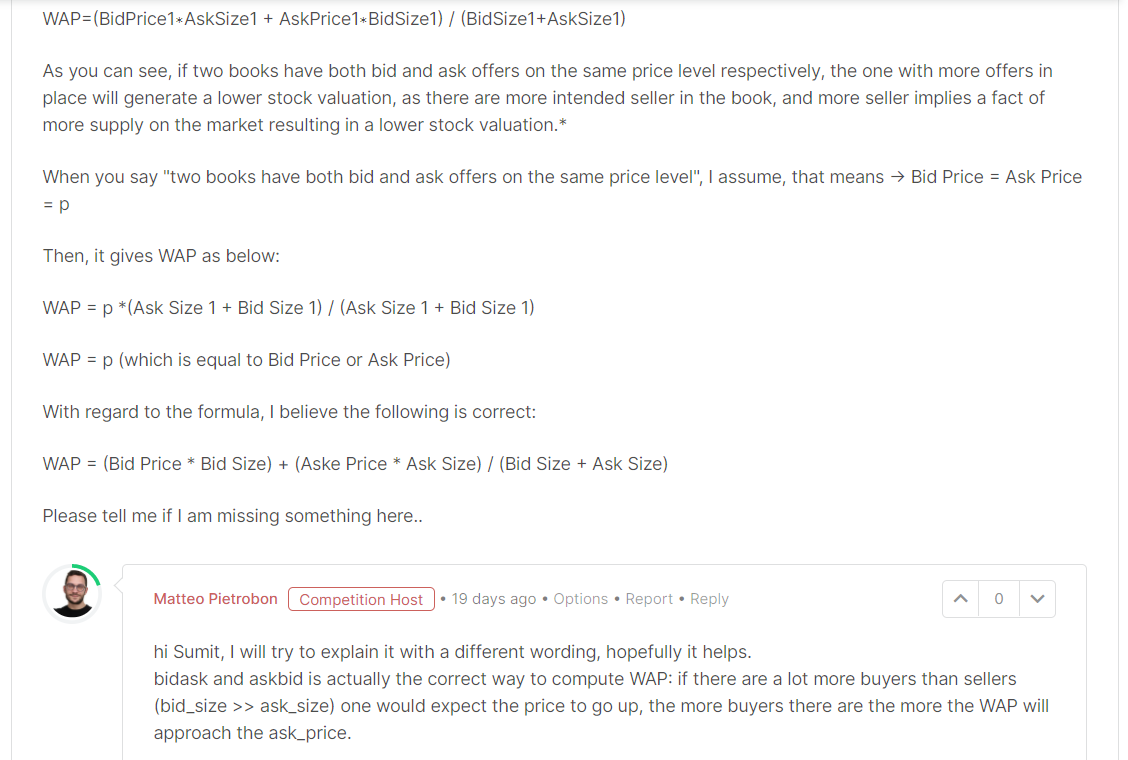



**Prediction**

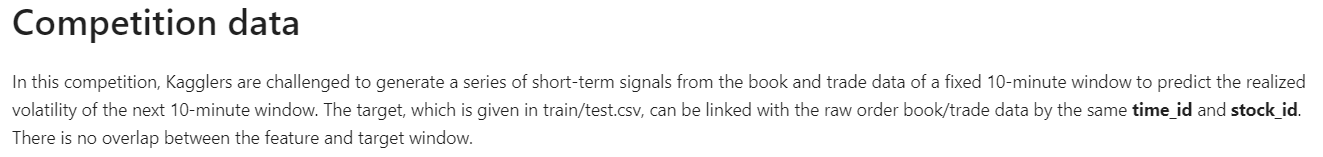




In [ ]:
train = pd.read_csv(os.path.join(path,'train.csv'))

In [ ]:
test = pd.read_csv(os.path.join(path,'test.csv'))

In [ ]:
train['row_id'] = train['stock_id'].astype('str') + '-' + train['time_id'].astype('str')

In [ ]:
test['row_id'] = test['stock_id'].astype('str') + '-' + test['time_id'].astype('str')

In [ ]:
test

**Reading the parquet files**

In [ ]:
book = pd.read_parquet(os.path.join(path,'book_train.parquet/stock_id=0'))
trade = pd.read_parquet(os.path.join(path,'trade_train.parquet/stock_id=0'))

In [ ]:
book.shape, trade.shape

In [ ]:
def calculate_wap(book_example):
    book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])
    
    return book_example

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [ ]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [ ]:
import os
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob(os.path.join(path,'book_train.parquet/*'))

In [ ]:
def realized_volatility_per_time_id(file_path,prediction_column_name):
    df_book_data = pd.read_parquet(file_path)
    
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [ ]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')

In [ ]:
#merge train and realized per time 
train = train.merge(df_past_realized_train, on='row_id',how='left')

In [ ]:
train.shape

In [ ]:
train.head()

Most of the time_id's are having 112 stocks

In [ ]:
train_stock_aggs = train.groupby('stock_id')['target'].agg(['mean','var','std']).reset_index()

In [ ]:
train_stock_aggs.head()

In [ ]:
fig = px.line(train_stock_aggs,x='stock_id',y=['mean','std'])
fig.show()

In [ ]:
fig = px.line(train_stock_aggs,x='stock_id',y=['var'])
fig.show()

Does this mean all the higher peaks will always result in higher volatility ??

In [ ]:
ax = sns.lineplot(x = "stock_id", y = "target", 
                  markers = True, dashes = False, data = train)
plt.axhline(train['target'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('stock vs target')
plt.xlabel('Stock_id')
plt.ylabel('target')
plt.legend(loc='best')

In [ ]:
ax = sns.lineplot(x = "stock_id", y = "target", 
                  markers = True, dashes = False, data = train)
plt.axhline(train['target'].std(), color='red', linestyle='--', linewidth=2, label='Std')
plt.xticks(rotation = 45)
plt.title('stock vs target')
plt.xlabel('Stock_id')
plt.ylabel('target')
plt.legend(loc='best')

In [ ]:
ax = sns.lineplot(x = "stock_id", y = "pred", 
                  markers = True, dashes = False, data = train)
plt.axhline(train['pred'].std(), color='red', linestyle='--', linewidth=2, label='Std')
plt.xticks(rotation = 45)
plt.title('stock vs pred')
plt.xlabel('Stock_id')
plt.ylabel('pred')
plt.legend(loc='best')

**processing trade data**

In [ ]:
list_trade_book_file_train = glob.glob(os.path.join(path,'trade_train.parquet/*'))

In [ ]:
def trade_per_time_id(file_path):
    df_trade_data = pd.read_parquet(file_path)
    target_df = df_trade_data.groupby('time_id')['price','order_count','size'].agg(['mean','var','std']).reset_index()
    target_df['stock_id'] = file_path.split('=')[1]
    target_df.columns = ['time_id','price_mean','price_var','price_std','order_count_mean','order_count_var','order_count_std',
                    'size_mean','size_var','size_std','stock_id']
    
    return target_df
    

In [ ]:
def trade_per_stock(list_file):
    df_past_trade = pd.DataFrame()
    for file in tqdm(list_file):
        df_past_trade = pd.concat([df_past_trade,
                                     trade_per_time_id(file)])
    return df_past_trade
df_past_trade_train = trade_per_stock(list_file=list_trade_book_file_train)

In [ ]:
df_past_trade_train['row_id'] = df_past_trade_train['stock_id'].astype('str') + '-' + df_past_trade_train['time_id'].astype('str')

In [ ]:
df_past_trade_train.drop(['time_id','stock_id'], axis=1, inplace=True)

In [ ]:
df_past_trade_train.shape

In [ ]:
train = train.merge(df_past_trade_train, on='row_id',how='left')

In [ ]:
train

In [ ]:
px.imshow(train.drop(['time_id','stock_id','row_id'],axis=1).corr())

columns : pred(realized volatility of past 10min), price_var and price_std(of trade data) are having higher correlation with target.

In [ ]:
#processing test files

In [ ]:
list_order_book_file_test = glob.glob(os.path.join(path,'book_test.parquet/*'))
list_trade_book_file_test = glob.glob(os.path.join(path,'trade_test.parquet/*'))

In [ ]:
df_past_realized_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
                                                           prediction_column_name='pred')
#merge test and realized per time
print(df_past_realized_test)
test = test.merge(df_past_realized_test, on='row_id',how='left')
df_past_trade_test = trade_per_stock(list_file=list_trade_book_file_test)

df_past_trade_test['row_id'] = df_past_trade_test['stock_id'].astype('str') + '-' + df_past_trade_test['time_id'].astype('str')

df_past_trade_test.drop(['time_id','stock_id'], axis=1, inplace=True)
print(df_past_trade_test)
test = test.merge(df_past_trade_test, on='row_id',how='left')

In [ ]:
test

## Making a prediction with basic fields

In [ ]:
group = GroupKFold(n_splits=5)
kfol = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
X = train[['stock_id','pred','price_var','price_std']]
Y = train['target']

In [ ]:
x_test = test[['stock_id','pred','price_var','price_std']]

In [ ]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [ ]:
# Create out of folds array
oof_predictions = np.zeros(X.shape[0])
# Create test array to store predictions
test_predictions = np.zeros(x_test.shape[0])

In [ ]:
seed = 29
params = {
        'learning_rate': 0.25,        
        'lambda_l1': 2.154360665259325,
        'lambda_l2': 6.711089761523827,
        'num_leaves': 2769,
        'min_sum_hessian_in_leaf': 20.44437160769411,
        'feature_fraction': 0.7921473067441019,
        'feature_fraction_bynode': 0.8083803860191322,
        'bagging_fraction': 0.9726755660563261,
        'bagging_freq': 42,
        'min_data_in_leaf': 1690,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }

In [ ]:
for fold, (trn_ind, val_ind) in enumerate(kfol.split(X, Y)):
    print(f'Training fold {fold + 1}')
    x_train, x_val = X.iloc[trn_ind], X.iloc[val_ind]
    y_train, y_val = Y.iloc[trn_ind], Y.iloc[val_ind]
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y_train)
    val_weights = 1 / np.square(y_val)
    train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
    val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
    model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 600, 
                          early_stopping_rounds = 67, 
                          verbose_eval = 200,
                          feval = feval_rmspe)
    oof_predictions[val_ind] = model.predict(x_val)
    test_predictions += model.predict(x_test) / 5
    plt.figure(figsize=(12,6))
    lgb.plot_importance(model, max_num_features=10)
    plt.title("Feature importance")
    plt.show()

In [ ]:
rmspe_score = rmspe(Y, oof_predictions)
print(f'Our out of folds RMSPE is {rmspe_score}')

In [ ]:
test_predictions

In [ ]:
test['target'] = test_predictions

In [ ]:
test = test[['row_id','target']]

In [ ]:
test.to_csv('submission.csv',index=False)